In [1]:
import os
os.chdir("c:/users/n886528/desktop")

import CIFI.models.macrovariables.macrovariables as macroseries
import CIFI.controllers.models.creconstruction17 as Cm
from CIFI.models.modelproperties.modelproperties import ModelProperties,NotConnectError 

import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import re
# Tree-based GBM
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

# STEPWISE

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,LinearRegression

In [2]:
# load in the database and the model
DataBase =  macroseries.ScenarioMacroSeries(
    mv_dict_list=[
        {
            "macro_variable_name": "FZFL075035503Q_US",
            "lag": 0,
            "transformation_type": "p1y",
            "macro_variables_group": "FZFL075035503Q_US_p1y"
        },
        {
            "macro_variable_name": "FHSTQ_US",
            "lag": 0,
            "transformation_type": "p1y",
            "macro_variables_group": "FHSTQ_US_p1y"
        },
        {
            "macro_variable_name": "FRGT5Y_US",
            "lag": 0,
            "transformation_type": "d1y",
            "macro_variables_group": "FRGT5Y_US_d1y"
        }
    ],
    mv_group_dict_list=[
        {
            "combination" : "FZFL075035503Q_US_p1y",
            "operand_1" : "FZFL075035503Q_US_p1y",
            "operand_2" : None,
            "operator" : None
        },
        {
            "combination": "FHSTQ_US_p1y",
            "operand_1": "FHSTQ_US_p1y",
            "operand_2": None,
            "operator": None
        },
        {
            "combination": "FRGT5Y_US_d1y",
            "operand_1": "FRGT5Y_US_d1y",
            "operand_2": None,
            "operator": None
        }
    ],
    mv_as_of_date=datetime.datetime(2006,3,31),
    mv_forecast_periods=50,
    mv_context='CCAR2017',
    mv_scenario='FRB_BASE',
    mv_geo_scope='National&Regional',
    mv_period_frequency='quarterly',
    debug=False
)

# datatemplate
datatemplate = DataBase.generateTransformedData()

# booksize

booksize = [('RESIDENTIAL', 3364726010.31, 'CRE_CONSTRUCTION'),
            ('RETAIL', 510710881.81, 'CRE_CONSTRUCTION'),
            ('MULTIFAMILY', 11387674772.28, 'CRE_CONSTRUCTION'),
            ('HOSPITALITY', 664253059.88, 'CRE_CONSTRUCTION'),
            ('INDUSTRIAL', 206732498.12, 'CRE_CONSTRUCTION'),
            ('OFFICE', 1516499836.44, 'CRE_CONSTRUCTION'),
            ('OTHER', 92692125.7, 'CRE_CONSTRUCTION')]

totalsize = sum([i[1] for i in booksize])

resisize = booksize[0][1]

#percentage calculation

resiper = resisize / totalsize
nonresiper = 1 - resiper

# dataGenerator
def CREdataGenerator(temp,size):
    
    global resiper
    global nonresiper

    per = [np.random.uniform(low = min(temp[i]), high=max(temp[i]), size = size ) for i in temp.columns.tolist()]
    per = np.asarray(per).T
    per_pd = pd.core.frame.DataFrame(per,columns = temp.columns.tolist())

    per_resi = per_pd[['FHSTQ_US_p1y','FRGT5Y_US_d1y']]
    machine_resi = lambda x: 1/ (1 + np.exp(-(-4.4464 + sum([i*j for i,j in zip([x['FHSTQ_US_p1y'],x['FRGT5Y_US_d1y']],[-2.09,-0.7488])]))))
    result_resi = per_resi.apply(machine_resi,axis = 1)

    per_non_resi = per_pd[["FHSTQ_US_p1y","FZFL075035503Q_US_p1y"]]
    machine_non_resi = lambda x: 1/(1 + np.exp(-(-5.5596 + sum([i*j for i,j in zip([x['FHSTQ_US_p1y'],x['FZFL075035503Q_US_p1y']],[-2.7609,-3.5105])]))))
    result_non_resi = per_non_resi.apply(machine_non_resi,axis=1)
    per_pd['el']  = resiper * result_resi + nonresiper * result_non_resi
    return per_pd   

n886528 | [2017-04-21 16:25:33] | None | Scenario Macro Series for CCAR2017 FRB_BASE | INFO | Validating input variables...
n886528 | [2017-04-21 16:25:34] | None | Scenario Macro Series for CCAR2017 FRB_BASE | INFO | Validating input date 2006-03-31 00:00:00...
n886528 | [2017-04-21 16:25:34] | None | Scenario Macro Series for CCAR2017 FRB_BASE | INFO | Validating some input dictionary...
n886528 | [2017-04-21 16:25:34] | None | Scenario Macro Series for CCAR2017 FRB_BASE | INFO | Validating input macro variables dictionary...
n886528 | [2017-04-21 16:25:34] | None | Scenario Macro Series for CCAR2017 FRB_BASE | INFO | Validating some input dictionary...
n886528 | [2017-04-21 16:25:34] | None | Scenario Macro Series for CCAR2017 FRB_BASE | INFO | Validating input forecast periods 50...
n886528 | [2017-04-21 16:25:34] | None | Scenario Macro Series for CCAR2017 FRB_BASE | INFO | Validating input macro variable names...
n886528 | [2017-04-21 16:25:34] | None | Scenario Macro Series for 

<h2>Summary</h2>
 <b>Model:</b> $f(x_s,x_c)=\alpha*\frac{1}{1+e^{-x_s*\beta_1}}+\beta*\frac{1}{1+e^{-x_s*\beta_1}}$, and $\alpha+\beta = 1$


In [3]:
# GET DATA
dat = CREdataGenerator(datatemplate,10000)

for i in dat.keys():
    pat = re.compile('(.*_.*_.*)|(el)')
    if not pat.match(i):
        del dat[i]

In [4]:
# TRAIN the MODEL
X_train, X_test, y_train, y_test = train_test_split(dat.iloc[:,0:3],dat.iloc[:,3],test_size=0.2,random_state=1)
clf = GradientBoostingRegressor(n_estimators = 1000, max_depth=2,learning_rate = 0.01, loss = 'huber',random_state=1, subsample = 0.5)
clf.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01,
             loss='huber', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=1, subsample=0.5, verbose=0,
             warm_start=False)

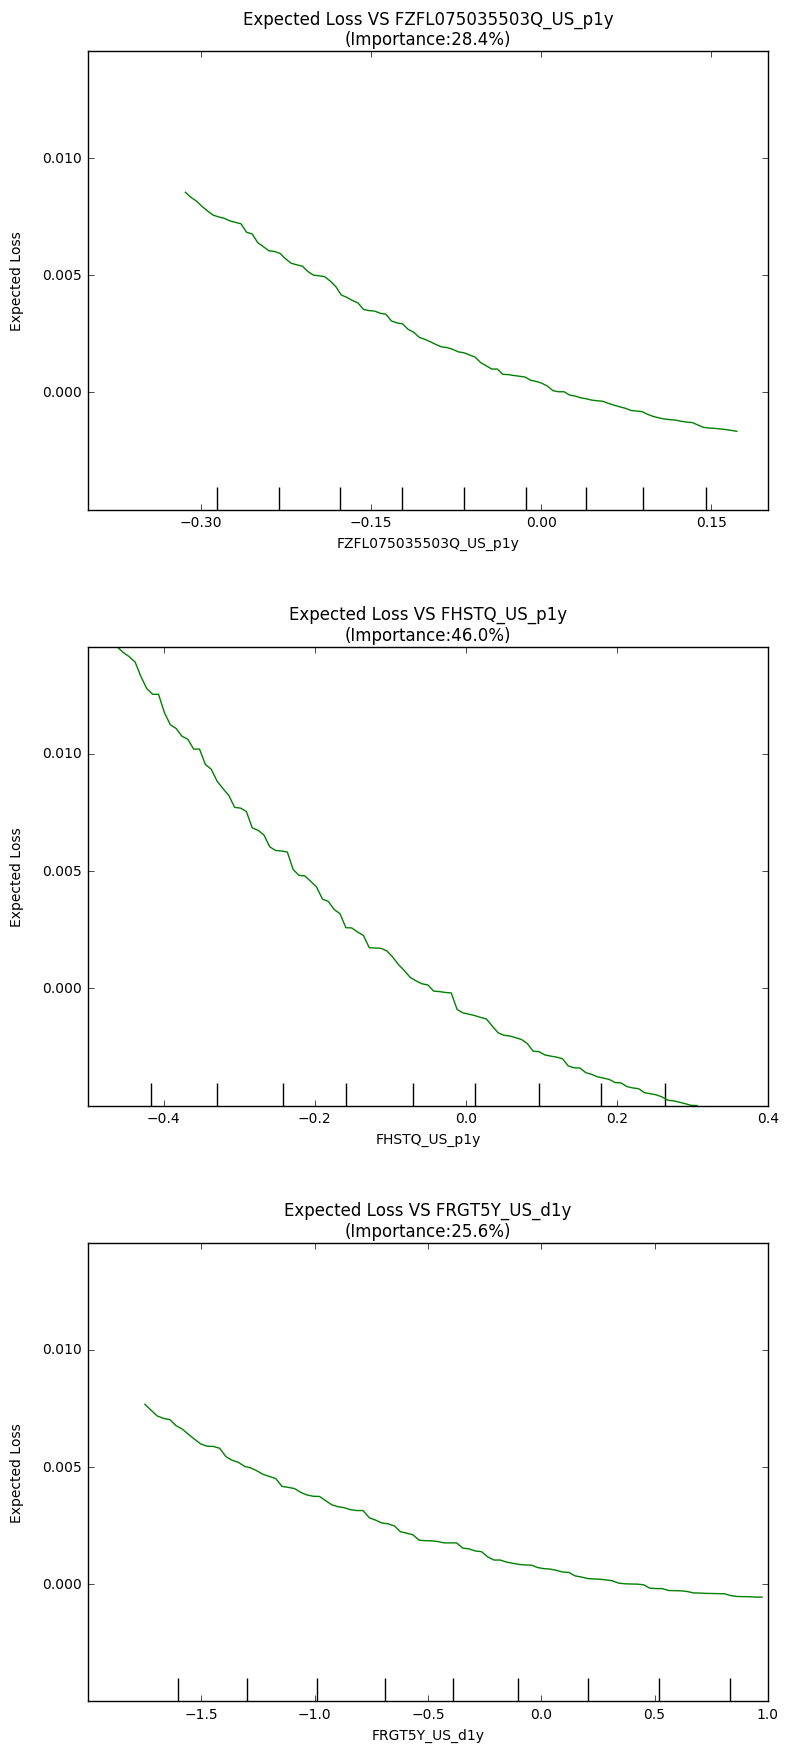

In [5]:
# Partial dependence plots 
importance = clf.feature_importances_
%matplotlib inline

fig,axs = plot_partial_dependence(clf,X_train,[0,1,2],figsize=(8,30),n_cols=1)
axs[0].set_xlabel(X_train.keys()[0])
axs[0].set_ylabel('Expected Loss')
axs[0].set_title('{0} VS {1}\n(Importance:{2}%)'.format('Expected Loss',X_train.keys()[0],np.round(importance[0],3)*100))
axs[1].set_xlabel(X_train.keys()[1])
axs[1].set_ylabel('Expected Loss')
axs[1].set_title('{0} VS {1}\n(Importance:{2}%)'.format('Expected Loss',X_train.keys()[1],np.round(importance[1],3)*100))
axs[2].set_xlabel(X_train.keys()[2])
axs[2].set_ylabel('Expected Loss')
axs[2].set_title('{0} VS {1}\n(Importance:{2}%)'.format('Expected Loss',X_train.keys()[2],np.round(importance[2],3)*100))
plt.show()

<h2>Note:</h2>

Partial dependence functions are defined by $f_S(X_S) = E_{X_C}f(X_S,X_C)$. 
represent the effect of $X_S$ on $f(X)$ after accounting for the (average)
effects of the other variables $X_C$ on $f(X)$. They are <b>not</b> the effect
of $X_S$ on $f(X)$ ignoring the effects of $X_C$.


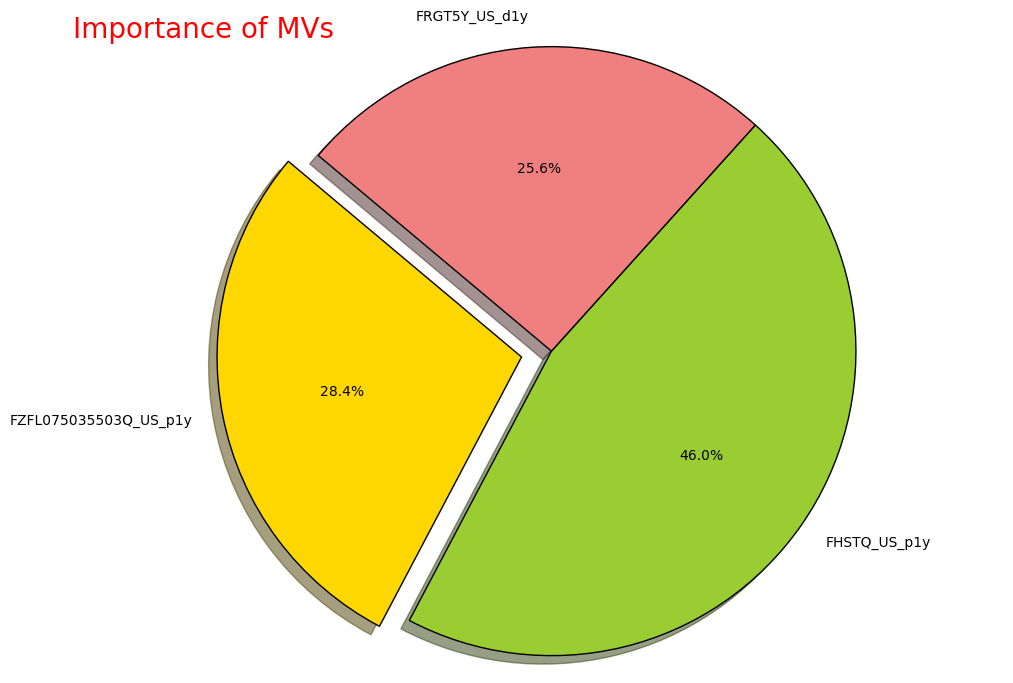

In [6]:
labels = X_test.keys()
sizes = importance
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice
 
# Plot
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
ax.axis('equal')
ax.set_title('Importance of MVs',loc = 'left',color = 'red',fontsize = 20)
plt.show()

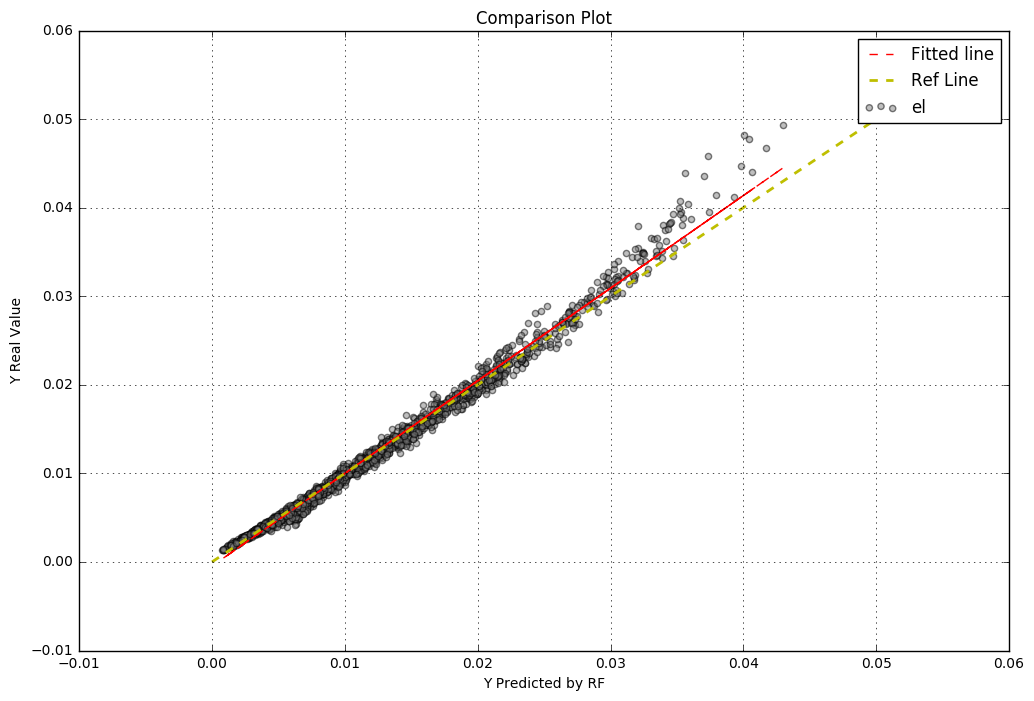

In [22]:
y_pred = clf.predict(X_test)

fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(y_pred,y_test,alpha = 0.5,c = 'grey')
ax.set_xlabel('Y Predicted by RF')
ax.set_ylabel('Y Real Value')
ax.set_title('Comparison Plot')
slope,intercept= np.polyfit(y_pred,y_test,1)
fitted = intercept + slope*y_pred
ax.plot(y_pred,fitted,'r--',label = 'Fitted line')
ax.plot(np.arange(0,0.05,0.0001),np.arange(0,0.05,0.0001),'y--',label = 'Ref Line',linewidth = 2)
ax.legend()
plt.grid(True)
plt.show()

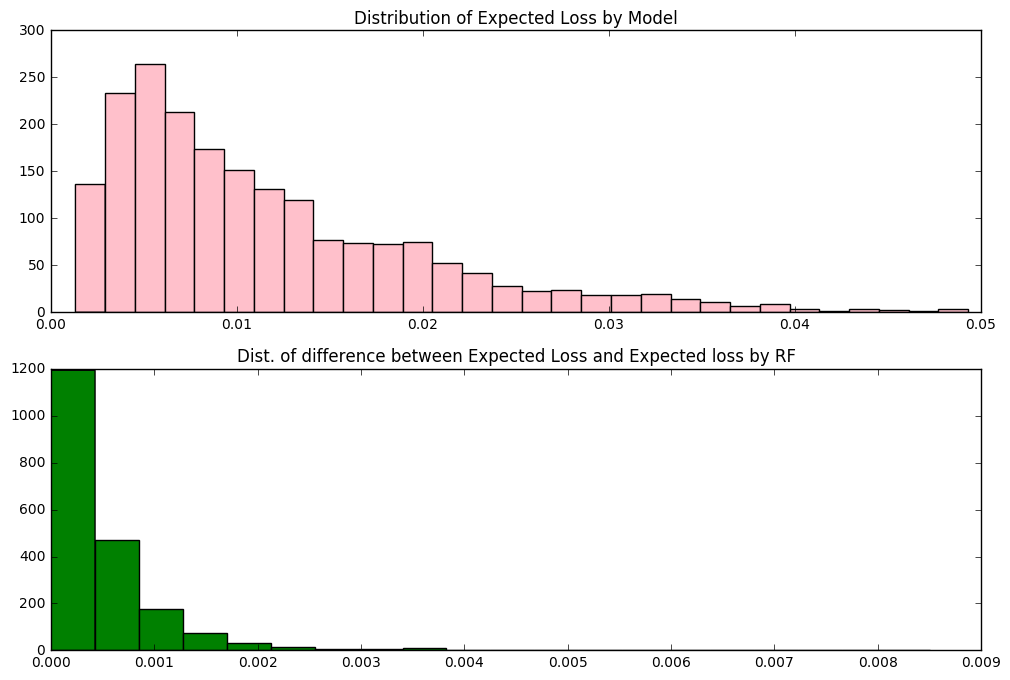

In [34]:
differ = np.abs(y_pred -y_test)
fig, ax = plt.subplots(2,1,figsize=(12,8))
ax[0].hist(y_test,bins = 30,color = 'pink')
ax[0].set_title('Distribution of Expected Loss by Model')
ax[1].hist(differ,bins =20,color = 'green')
ax[1].set_title('Dist. of difference between Expected Loss and Expected loss by RF')
plt.show()
